# Table of Contents
1. [Correlation Matrix Drop](#corr)
2. [Variance Inflation Factor Drop](#vif)
3. [Spearman Hierarchy Ward](#sp)

In [1]:
import numpy as np
import pandas as pd
import gc
import time
from contextlib import contextmanager
import lightgbm as lgb
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import KFold, StratifiedKFold
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from scipy.stats import spearmanr
from scipy.cluster import hierarchy
warnings.simplefilter(action='ignore', category=FutureWarning)

/opt/anaconda3/lib/python3.7/site-packages/lightgbm/__init__.py:48: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


### Reading in  files
Full training set of 829 features

In [2]:
df=pd.read_csv('o_full_train')
target=df['TARGET']
train=df.drop(columns='TARGET')

In [3]:
#spearman ward with incconsistency level 2
sp2=['NEW_EXT_SOURCES_MEAN',
 'prev_score_mean',
 'buro_score_sum',
 'prev_score_max',
 'external_1_refill',
 'EXT_SOURCE_2',
 'INTEREST',
 'app EXT_SOURCE_2 * DAYS_EMPLOYED',
 'buro_score_max',
 'app EXT_SOURCE_1 / DAYS_BIRTH',
 'DOWN_PAYMENT',
 'app EXT_SOURCE_1 * EXT_SOURCE_2',
 'NEW_CREDIT_TO_ANNUITY_RATIO',
 'AMT_ANNUITY',
 'app EXT_SOURCE_2 / DAYS_BIRTH',
 'DAYS_BIRTH',
 'LATE_PAYMENT',
 'app EXT_SOURCE_3 / DAYS_BIRTH',
 'CRED_UTIL_2',
 'ACTIVE_AMT_CREDIT_DEBT_RATE_MAX',
 'external_3_refill',
 'NEW_CREDIT_TO_GOODS_RATIO',
 'DAYS_ID_PUBLISH',
 'INSTAL_AMT_PAYMENT_SUM',
 'NAME_EDUCATION_TYPE_Higher education',
 'NEW_ANNUITY_TO_INCOME_RATIO',
 'NEW_EMPLOY_TO_BIRTH_RATIO',
 'POS_MONTHS_BALANCE_MAX',
 'CLOSED_DAYS_CREDIT_MAX',
 'OWN_CAR_AGE',
 'ACTIVE_AMT_CREDIT_SUM_SUM',
 'POS_MONTHS_BALANCE_MEAN',
 'NEW_CAR_TO_BIRTH_RATIO',
 'INSTAL_DPD_MEAN',
 'POS_COUNT',
 'ACTIVE_DAYS_CREDIT_MAX',
 'PREV_length_of_loan_MEAN',
 'BURO_DAYS_CREDIT_ENDDATE_MAX',
 'ACTIVE_DAYS_CREDIT_ENDDATE_MIN',
 'INSTAL_AMT_PAYMENT_MIN',
 'PREV_days_late_due_MEAN',
 'NEW_PHONE_TO_EMPLOY_RATIO',
 'NEW_RATIO_BURO_DAYS_CREDIT_MAX',
 '60_DAYSAMT_PAYMENT_MIN',
 'DAYS_LAST_PHONE_CHANGE',
 'ACTIVE_AMT_CREDIT_DEBT_RATE_MEAN',
 'BURO_AMT_CREDIT_SUM_DEBT_MEAN',
 'INSTAL_PAYMENT_DIFF_MEAN',
 'BURO_AMT_CREDIT_SUM_SUM',
 'INSTAL_AMT_PAYMENT_MEAN',
 'BURO_AMT_CREDIT_MAX_OVERDUE_MEAN',
 'APPROVED_PREV_CRED_TO_ANNUITY_RATIO_MAX',
 'ACTIVE_AMT_CREDIT_DEBT_RATE_VAR',
 'NEW_RATIO_BURO_AMT_CREDIT_SUM_SUM',
 'INSTAL_DBD_MAX',
 'prev_score_sum',
 'POS_NAME_CONTRACT_STATUS_Active_MEAN',
 'PREV_APP_CREDIT_PERC_VAR',
 'CLOSED_DAYS_CREDIT_VAR',
 'CLOSED_AMT_CREDIT_SUM_SUM',
 'BURO_DAYS_CREDIT_MEAN',
 'NEW_RATIO_BURO_DAYS_CREDIT_ENDDATE_MAX',
 'APPROVED_AMT_DOWN_PAYMENT_MAX',
 'ACTIVE_DAYS_CREDIT_MEAN',
 'APPROVED_INTEREST_SHARE_PREV_MEAN',
 'INSTAL_DAYS_ENTRY_PAYMENT_SUM',
 'NEW_INC_PER_CHLD',
 'APPROVED_INTEREST_PREV_MAX',
 'CLOSED_MONTHS_BALANCE_SIZE_MEAN',
 'POS_NAME_CONTRACT_STATUS_Completed_MEAN',
 'APPROVED_AMT_ANNUITY_MIN',
 'PREV_HOUR_APPR_PROCESS_START_MEAN',
 '60_DAYSAMT_INSTALMENT_SUM',
 'APPROVED_APP_CREDIT_PERC_MIN',
 'APPROVED_PREV_CRED_TO_ANNUITY_RATIO_MIN']

In [4]:
train=train[sp2]
t1=train

### Method to remove columns with lots of missing values

In [5]:
def remove_missing_columns(train, threshold = 90):
    # Calculate missing stats for train and test (remember to calculate a percent!)
    train_miss = pd.DataFrame(train.isnull().sum())
    train_miss['percent'] = 100 * train_miss[0] / len(train)
    
    
    # list of missing columns for train and test
    missing_train_columns = list(train_miss.index[train_miss['percent'] > threshold])
    
    # Combine the two lists together
    missing_columns = list(set(missing_train_columns))
    
    # Print information
    print('There are %d columns with greater than %d%% missing values.' % (len(missing_columns), threshold))
    
    # Drop the missing columns and return
    train = train.drop(columns = missing_columns)
    
    return train

## Correlation Matrix Drop by Magnitude
<a class="anchor" id="corr"></a>

In [6]:
# Threshold for removing correlated variables
threshold = 0.9

# Absolute value correlation matrix
corr_matrix = train.corr().abs()
corr_matrix.head()

,NEW_EXT_SOURCES_MEAN,prev_score_mean,buro_score_sum,prev_score_max,external_1_refill,EXT_SOURCE_2,INTEREST,app EXT_SOURCE_2 * DAYS_EMPLOYED,buro_score_max,app EXT_SOURCE_1 / DAYS_BIRTH,...,INSTAL_DAYS_ENTRY_PAYMENT_SUM,NEW_INC_PER_CHLD,APPROVED_INTEREST_PREV_MAX,CLOSED_MONTHS_BALANCE_SIZE_MEAN,POS_NAME_CONTRACT_STATUS_Completed_MEAN,APPROVED_AMT_ANNUITY_MIN,PREV_HOUR_APPR_PROCESS_START_MEAN,60_DAYSAMT_INSTALMENT_SUM,APPROVED_APP_CREDIT_PERC_MIN,APPROVED_PREV_CRED_TO_ANNUITY_RATIO_MIN
NEW_EXT_SOURCES_MEAN,1.000000,0.291105,0.328794,0.272296,0.333550,0.745663,0.029722,0.373597,0.371519,0.538650,...,0.080303,0.068996,0.043855,0.223001,0.006954,0.088573,0.116521,0.051506,0.009427,0.012745
prev_score_mean,0.291105,1.000000,0.270268,0.817985,0.324782,0.164890,0.016246,0.181672,0.263710,0.129054,...,0.198039,0.074884,0.004698,0.167393,0.007141,0.105250,0.051422,0.075826,0.022303,0.141598
buro_score_sum,0.328794,0.270268,1.000000,0.263388,0.205434,0.145729,0.033126,0.151399,0.668624,0.114009,...,0.055980,0.065274,0.015569,0.344338,0.001561,0.060362,0.042748,0.042170,0.009450,0.027843
prev_score_max,0.272296,0.817985,0.263388,1.000000,0.271278,0.147555,0.060906,0.148415,0.273899,0.121847,...,0.028200,0.041147,0.108327,0.151986,0.017534,0.164534,0.078906,0.004619,0.118017,0.012636
external_1_refill,0.333550,0.324782,0.205434,0.271278,1.000000,0.256406,0.007416,0.415197,0.182785,NaN,...,0.139313,0.127994,0.088323,0.173880,0.059724,0.103765,0.029228,0.064896,0.016154,0.059475


In [7]:
# Upper triangle of correlations
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
upper.head()

,NEW_EXT_SOURCES_MEAN,prev_score_mean,buro_score_sum,prev_score_max,external_1_refill,EXT_SOURCE_2,INTEREST,app EXT_SOURCE_2 * DAYS_EMPLOYED,buro_score_max,app EXT_SOURCE_1 / DAYS_BIRTH,...,INSTAL_DAYS_ENTRY_PAYMENT_SUM,NEW_INC_PER_CHLD,APPROVED_INTEREST_PREV_MAX,CLOSED_MONTHS_BALANCE_SIZE_MEAN,POS_NAME_CONTRACT_STATUS_Completed_MEAN,APPROVED_AMT_ANNUITY_MIN,PREV_HOUR_APPR_PROCESS_START_MEAN,60_DAYSAMT_INSTALMENT_SUM,APPROVED_APP_CREDIT_PERC_MIN,APPROVED_PREV_CRED_TO_ANNUITY_RATIO_MIN
NEW_EXT_SOURCES_MEAN,NaN,0.291105,0.328794,0.272296,0.333550,0.745663,0.029722,0.373597,0.371519,0.538650,...,0.080303,0.068996,0.043855,0.223001,0.006954,0.088573,0.116521,0.051506,0.009427,0.012745
prev_score_mean,NaN,NaN,0.270268,0.817985,0.324782,0.164890,0.016246,0.181672,0.263710,0.129054,...,0.198039,0.074884,0.004698,0.167393,0.007141,0.105250,0.051422,0.075826,0.022303,0.141598
buro_score_sum,NaN,NaN,NaN,0.263388,0.205434,0.145729,0.033126,0.151399,0.668624,0.114009,...,0.055980,0.065274,0.015569,0.344338,0.001561,0.060362,0.042748,0.042170,0.009450,0.027843
prev_score_max,NaN,NaN,NaN,NaN,0.271278,0.147555,0.060906,0.148415,0.273899,0.121847,...,0.028200,0.041147,0.108327,0.151986,0.017534,0.164534,0.078906,0.004619,0.118017,0.012636
external_1_refill,NaN,NaN,NaN,NaN,NaN,0.256406,0.007416,0.415197,0.182785,NaN,...,0.139313,0.127994,0.088323,0.173880,0.059724,0.103765,0.029228,0.064896,0.016154,0.059475


### Dropping one per pair of correlated variables

In [8]:
# Select columns with correlations above threshold
to_drop = [column for column in upper.columns if any(upper[column] > threshold)]

print('There are %d columns to remove.' % (len(to_drop)))

There are 2 columns to remove.


In [9]:
train = train.drop(columns = to_drop)

## Variance Inflation Factor Multicollinearity Reduction
<a class="anchor" id="vif"></a>
VIF quantifies how much the variance is inflated (variance inflates as collinearity increases)
VIF = 1/(1-R^2(j))
Explanation: R^2(j) is the R^2 obtained by regressing the jth predictor on the rest of the features

### Checking for nulls and infinites

In [10]:
train = remove_missing_columns(train)

There are 0 columns with greater than 90% missing values.


In [11]:
train=train.replace([np.inf, -np.inf], np.nan)
train.fillna(train.median(),inplace=True)

In [12]:
train.isnull().values.any()

False

In [13]:
np.isfinite(train).values.all()

True

In [14]:
# feature_cols=['prev_score_mean', 'prev_score_max', 'EXT_SOURCE_2', 'buro_score_mean',
#        'EXT_SOURCE_3', 'buro_score_sum', 'external_1_refill',
#        'app EXT_SOURCE_2 / DAYS_BIRTH', 'INTEREST',
#        'app EXT_SOURCE_1 / DAYS_BIRTH', 'buro_score_recent2y_sum',
#        'app EXT_SOURCE_1 * EXT_SOURCE_2', 'app EXT_SOURCE_3 / DAYS_BIRTH',
#        'prev_score_last', 'DAYS_EMPLOYED', 'DOWN_PAYMENT', 'NEW_SOURCES_PROD',
#        'NEW_CREDIT_TO_ANNUITY_RATIO/3', 'NEW_CREDIT_TO_ANNUITY_RATIO',
#        'buro_score_max', 'AMT_ANNUITY', 'CNT_PAYMENT',
#        'app EXT_SOURCE_1 * EXT_SOURCE_3', 'DAYS_BIRTH', 'LATE_PAYMENT',
#        'EXT_SOURCE_1', 'BURO_AMT_CREDIT_DEBT_RATE_MAX',
#        'INSTAL_AMT_INSTALMENT_SUM', 'AMT_CREDIT', 'CRED_UTIL_2',
#        'prev_score_var', 'CODE_GENDER', 'external_3_refill', 'DAYS_ID_PUBLISH',
#        'NEW_CREDIT_TO_GOODS_RATIO', 'BURO_AMT_CREDIT_DEBT_RATE_VAR',
#        'PREV_days_late_due_MEAN', 'buro_score_last',
#        'NEW_ANNUITY_TO_INCOME_RATIO', 'INSTAL_DAYS_ENTRY_PAYMENT_MAX',
#        'REGION_POPULATION_RELATIVE', 'NEW_CAR_TO_EMPLOY_RATIO',
#        'POS_MONTHS_BALANCE_MEAN', 'INTEREST_SHARE', 'buro_score_var',
#        'OWN_CAR_AGE', 'CLOSED_DAYS_CREDIT_MAX',
#        'NAME_EDUCATION_TYPE_Higher education', 'POS_COUNT',
#        'PREV_days_late_due_MIN', 'APPROVED_DAYS_DECISION_MAX',
#        'NEW_SCORES_STD', 'INSTAL_DPD_MEAN', 'NEW_PHONE_TO_EMPLOY_RATIO',
#        '60_DAYSAMT_PAYMENT_MIN', 'POS_MONTHS_BALANCE_MAX', 'DAYS_REGISTRATION',
#        'BURO_AMT_CREDIT_SUM_SUM', 'ACTIVE_AMT_CREDIT_SUM_MEAN',
#        'ACTIVE_AMT_CREDIT_SUM_DEBT_MEAN', 'CLOSED_DAYS_CREDIT_ENDDATE_MAX',
#        'ACTIVE_AMT_CREDIT_SUM_MAX', '60_DAYSAMT_INSTALMENT_MAX',
#        'ACTIVE_DAYS_CREDIT_MAX', 'PREV_DAYS_DECISION_MEAN',
#        'PREV_DAYS_DECISION_MAX', 'DAYS_LAST_PHONE_CHANGE',
#        'BURO_DAYS_CREDIT_ENDDATE_MAX', 'INSTAL_DBD_SUM',
#        'BURO_DAYS_CREDIT_MAX', 'NEW_CREDIT_TO_INCOME_RATIO',
#              'NAME_FAMILY_STATUS_Married',
#        'NAME_EDUCATION_TYPE_Secondary / secondary special',
#        'NEW_RATIO_BURO_AMT_CREDIT_SUM_MAX', 'NEW_RATIO_BURO_DAYS_CREDIT_MAX',
#        'prev_score_recent2y_sum', 'BURO_AMT_CREDIT_SUM_DEBT_MEAN',
#        'ACTIVE_DAYS_CREDIT_ENDDATE_MEAN', 'ACTIVE_DAYS_CREDIT_ENDDATE_MIN',
#        'BURO_AMT_CREDIT_MAX_OVERDUE_MEAN', 'INSTAL_AMT_INSTALMENT_MEAN',
#        'APARTMENTS_AVG', 'ACTIVE_DAYS_CREDIT_UPDATE_MEAN',
#        'BURO_AMT_CREDIT_SUM_DEBT_MAX',
#        'APPROVED_PREV_CRED_TO_ANNUITY_RATIO_MAX','YEARS_BEGINEXPLUATATION_AVG', 'INSTAL_DAYS_ENTRY_PAYMENT_SUM',
#        'INSTAL_AMT_INSTALMENT_MAX', 'ACTIVE_AMT_CREDIT_DEBT_RATE_SUM',
#        'INSTAL_AMT_PAYMENT_MIN', 'INSTAL_DBD_MEAN', 'PREV_CNT_PAYMENT_MEAN',
#        'PREV_APP_CREDIT_PERC_VAR', 'DEF_30_CNT_SOCIAL_CIRCLE',
#        'PREV_APP_CREDIT_PERC_MAX', 'INSTAL_PAYMENT_DIFF_MEAN',
#        '60_DAYSDAYS_ENTRY_PAYMENT_MEAN', 'APPROVED_AMT_APPLICATION_MAX',
#        '60_DAYSAMT_INSTALMENT_MEAN', 'PREV_AMT_DOWN_PAYMENT_MAX']

In [15]:
feature_cols=[f for f in train.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index','Unnamed: 0']]
#features_cols=final_features

### Columns to drop with >10 variance inflation factor

In [16]:
#only dropping ONE per pair from the list of >10 VIF
to_drop=['prev_score_max', 
         'app EXT_SOURCE_2 / DAYS_BIRTH', 
         'AMT_CREDIT', '60_DAYSAMT_INSTALMENT_MEAN', 
         'BURO_AMT_CREDIT_SUM_DEBT_MAX', 'ACTIVE_DAYS_CREDIT_ENDDATE_MEAN', 
         'ACTIVE_AMT_CREDIT_SUM_DEBT_MEAN', 'NEW_SOURCES_PROD','NEW_CREDIT_TO_INCOME_RATIO', 'PREV_DAYS_DECISION_MEAN',
        'BURO_AMT_CREDIT_DEBT_RATE_MAX']

In [17]:
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor


X = train[feature_cols]
#train=train.drop(columns=to_drop)

vif = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif)

[5.775552799276808, 4.553202212202727, 2.206468257114486, 5.154179128129167, 2.07631426103033, 10.475541552626446, 1.2635914337957312, 6.027794132288101, 2.357533282931215, 2.3265671384119226, 3.4307570082130754, 1.7339032469419486, 1.4953545701051554, 2.3124935073949895, 12.452992796407592, 3.272143872115533, 1.3242011422945097, 2.6787314275699052, 1.269874802819796, 3.04657567324231, 0.9060312016975078, 2.4943915258356655, 1.1296381293060258, 3.5315279158384487, 1.1694263226808281, 1.7692274376324995, 5.314643609897508, 3.3194125410006086, 2.1864176556354797, 1.011023714728315, 22.35804710317793, 3.8471181488545154, 1.344058587651451, 2.897299231027693, 3.6200986803540767, 4.233131174067265, 1.3477055825910194, 1.2606903465445114, 2.204101778273133, 1.0429959721381998, 1.1651558621471054, 1.4781870379093776, 1.289910329306184, 4.428063827602724, 1.4985245197639876, 1.3532677370213753, 76.25348644306334, 3.789672099698634, 1.0023391698845794, 3.0568484089172276, 2.86092957217606, 1.00

In [18]:
vifs=pd.DataFrame()
vifs['feature']=X.columns
vifs['VIF']=vif

In [19]:
vifs.head(50)

,feature,VIF
0,NEW_EXT_SOURCES_MEAN,5.775553
1,prev_score_mean,4.553202
2,buro_score_sum,2.206468
3,prev_score_max,5.154179
4,external_1_refill,2.076314
5,EXT_SOURCE_2,10.475542
6,INTEREST,1.263591
7,app EXT_SOURCE_2 * DAYS_EMPLOYED,6.027794
8,buro_score_max,2.357533
9,app EXT_SOURCE_1 / DAYS_BIRTH,2.326567


In [20]:
vifs.tail(50)

,feature,VIF
23,INSTAL_AMT_PAYMENT_SUM,3.531528
24,NAME_EDUCATION_TYPE_Higher education,1.169426
25,NEW_ANNUITY_TO_INCOME_RATIO,1.769227
26,NEW_EMPLOY_TO_BIRTH_RATIO,5.314644
27,POS_MONTHS_BALANCE_MAX,3.319413
28,CLOSED_DAYS_CREDIT_MAX,2.186418
29,OWN_CAR_AGE,1.011024
30,ACTIVE_AMT_CREDIT_SUM_SUM,22.358047
31,POS_MONTHS_BALANCE_MEAN,3.847118
32,INSTAL_DPD_MEAN,1.344059


In [21]:
train['TARGET']=target
train.to_csv(r'col_full_train')

print('Training shape: ', train.shape)

Training shape:  (356251, 74)


## Spearman Hierarchy Correlation
<a class="anchor" id="sp"></a>

In [22]:
from collections import defaultdict

import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import spearmanr
from scipy.cluster import hierarchy

In [23]:
train2=pd.read_csv('o_full_train')

In [24]:
ft=['prev_score_mean', 'EXT_SOURCE_2', 'buro_score_mean', 'EXT_SOURCE_3',
       'buro_score_sum', 'external_1_refill', 'INTEREST',
       'app EXT_SOURCE_1 / DAYS_BIRTH', 'buro_score_recent2y_sum',
       'app EXT_SOURCE_1 * EXT_SOURCE_2', 'app EXT_SOURCE_3 / DAYS_BIRTH',
       'prev_score_last', 'DAYS_EMPLOYED', 'DOWN_PAYMENT',
       'NEW_CREDIT_TO_ANNUITY_RATIO/3', 'NEW_CREDIT_TO_ANNUITY_RATIO',
       'buro_score_max', 'AMT_ANNUITY', 'CNT_PAYMENT',
       'app EXT_SOURCE_1 * EXT_SOURCE_3', 'DAYS_BIRTH']

In [25]:
ft=['NEW_EXT_SOURCES_MEAN', 'prev_score_mean',
       'app EXT_SOURCE_2 * EXT_SOURCE_3', 'buro_score_sum', 'prev_score_max',
       'buro_score_mean', 'external_1_refill', 'EXT_SOURCE_2', 'INTEREST',
       'app EXT_SOURCE_2 * DAYS_EMPLOYED', 'buro_score_max', 'prev_score_last',
       'app EXT_SOURCE_1 / DAYS_BIRTH', 'DOWN_PAYMENT', 'EXT_SOURCE_3',
       'buro_score_recent2y_sum', 'app EXT_SOURCE_1 * EXT_SOURCE_2',
       'NEW_CREDIT_TO_ANNUITY_RATIO', 'CNT_PAYMENT', 'AMT_ANNUITY',
       'app EXT_SOURCE_2 / DAYS_BIRTH', 'DAYS_BIRTH', 'LATE_PAYMENT',
       'app EXT_SOURCE_3 / DAYS_BIRTH', 'CRED_UTIL_2',
       'ACTIVE_AMT_CREDIT_DEBT_RATE_MAX', 'external_3_refill', 'CODE_GENDER',
       'AMT_CREDIT', 'NEW_CREDIT_TO_GOODS_RATIO',
       'NEW_CREDIT_TO_ANNUITY_RATIO/3', 'NEW_SOURCES_PROD', 'DAYS_ID_PUBLISH',
       'INSTAL_AMT_PAYMENT_SUM', 'app EXT_SOURCE_3 * DAYS_EMPLOYED',
       'NAME_EDUCATION_TYPE_Higher education', 'NEW_ANNUITY_TO_INCOME_RATIO',
       'NEW_EMPLOY_TO_BIRTH_RATIO', 'INTEREST_SHARE', 'EXT_SOURCE_1',
       'buro_score_var', 'REGION_POPULATION_RELATIVE', 'AMT_GOODS_PRICE',
       'DAYS_EMPLOYED', 'POS_MONTHS_BALANCE_MAX', 'AGE_INT',
       'CLOSED_DAYS_CREDIT_MAX', 'prev_score_var',
       'BURO_AMT_CREDIT_DEBT_RATE_VAR', 'app EXT_SOURCE_1 * EXT_SOURCE_3',
       'OWN_CAR_AGE', 'INSTAL_DAYS_ENTRY_PAYMENT_MAX',
       'ACTIVE_AMT_CREDIT_SUM_SUM', 'POS_MONTHS_BALANCE_MEAN',
       'INSTAL_AMT_INSTALMENT_SUM',
       'NAME_EDUCATION_TYPE_Secondary / secondary special',
       'NEW_CAR_TO_BIRTH_RATIO', 'APPROVED_DAYS_DECISION_MAX',
       'INSTAL_DPD_MEAN', 'buro_score_last', 'POS_COUNT', 'DAYS_REGISTRATION',
       'CLOSED_DAYS_CREDIT_ENDDATE_MAX', 'BURO_AMT_CREDIT_DEBT_RATE_MAX',
       'ACTIVE_DAYS_CREDIT_MAX', 'PREV_DAYS_DECISION_MAX',
       'NAME_FAMILY_STATUS_Married', 'PREV_length_of_loan_MEAN',
       'BURO_DAYS_CREDIT_ENDDATE_MAX', 'ACTIVE_DAYS_CREDIT_ENDDATE_MIN',
       'NEW_CAR_TO_EMPLOY_RATIO', 'INSTAL_AMT_PAYMENT_MIN',
       'NEW_CREDIT_TO_INCOME_RATIO', 'PREV_days_late_due_MEAN',
       'DEF_30_CNT_SOCIAL_CIRCLE', 'NEW_PHONE_TO_EMPLOY_RATIO',
       'ACTIVE_AMT_CREDIT_SUM_MAX', 'prev_score_recent2y_sum',
       'NEW_PHONE_TO_BIRTH_RATIO', 'ACTIVE_DAYS_CREDIT_UPDATE_MEAN',
       'NEW_RATIO_BURO_DAYS_CREDIT_MAX', '60_DAYSAMT_PAYMENT_MIN',
       'INSTAL_DBD_SUM', 'APPROVED_DAYS_DECISION_MEAN', 'BURO_DAYS_CREDIT_MAX',
       'ACTIVE_AMT_CREDIT_SUM_DEBT_MEAN', 'DAYS_LAST_PHONE_CHANGE',
       'ACTIVE_AMT_CREDIT_DEBT_RATE_MEAN', 'ACTIVE_AMT_CREDIT_SUM_MEAN',
       'BURO_AMT_CREDIT_SUM_DEBT_MEAN', 'PREV_days_late_due_MIN',
       'ACTIVE_DAYS_CREDIT_ENDDATE_MEAN', 'INSTAL_DAYS_ENTRY_PAYMENT_MEAN',
       'PREV_DAYS_DECISION_MEAN', 'INSTAL_PAYMENT_DIFF_MEAN',
       'BURO_AMT_CREDIT_SUM_SUM', 'INSTAL_DBD_MEAN', 'NEW_DOC_IND_KURT',
       'INSTAL_AMT_PAYMENT_MEAN', 'BURO_AMT_CREDIT_MAX_OVERDUE_MEAN', 
        'NEW_SCORES_STD', 'APPROVED_PREV_CRED_TO_ANNUITY_RATIO_MAX',
       'INSTAL_PAYMENT_PERC_SUM', 'ACTIVE_AMT_CREDIT_SUM_DEBT_MAX',
       'ACTIVE_AMT_CREDIT_DEBT_RATE_VAR', 'ACTIVE_AMT_CREDIT_SUM_DEBT_SUM',
       'NEW_RATIO_BURO_AMT_CREDIT_SUM_SUM', 'INSTAL_DBD_MAX', 'prev_score_sum',
       'POS_NAME_CONTRACT_STATUS_Active_MEAN',
       'NEW_RATIO_BURO_AMT_CREDIT_SUM_MEAN', 'PREV_APP_CREDIT_PERC_VAR',
       'BURO_STATUS_0_MEAN_MEAN', 'INSTAL_PAYMENT_PERC_MEAN',
       'BURO_AMT_CREDIT_DEBT_RATE_MEAN', 'APPROVED_APP_CREDIT_PERC_VAR',
       'CLOSED_DAYS_CREDIT_VAR', 'CLOSED_AMT_CREDIT_SUM_SUM',
       'NEW_RATIO_BURO_AMT_CREDIT_SUM_MAX', 'BURO_DAYS_CREDIT_ENDDATE_MEAN',
       'PREV_length_of_loan_MAX', 'BURO_DAYS_CREDIT_MEAN',
       'INSTAL_PAYMENT_DIFF_SUM', 'BURO_AMT_CREDIT_SUM_MAX',
       'PREV_CNT_PAYMENT_MEAN', 'NEW_RATIO_BURO_DAYS_CREDIT_ENDDATE_MAX',
       'APPROVED_AMT_DOWN_PAYMENT_MAX', 'ACTIVE_DAYS_CREDIT_MEAN',
       'ACTIVE_AMT_CREDIT_DEBT_RATE_MIN', 'app EXT_SOURCE_1 * DAYS_EMPLOYED',
       'APPROVED_INTEREST_SHARE_PREV_MEAN', 'CLOSED_DAYS_CREDIT_UPDATE_MEAN',
       'INSTAL_DAYS_ENTRY_PAYMENT_SUM', 'CLOSED_AMT_CREDIT_SUM_MEAN',
       'BURO_AMT_CREDIT_SUM_MEAN', 'NEW_INC_PER_CHLD', 'INSTAL_DPD_SUM',
       'CLOSED_DAYS_CREDIT_MEAN', 'CLOSED_DAYS_CREDIT_ENDDATE_MEAN',
       'AMT_INCOME_TOTAL', 'ACTIVE_DAYS_CREDIT_ENDDATE_MAX',
       'NEW_RATIO_BURO_DAYS_CREDIT_UPDATE_MEAN', 'INSTAL_AMT_INSTALMENT_MAX',
       'BURO_AMT_CREDIT_SUM_DEBT_MAX', 'APPROVED_INTEREST_PREV_MAX',
       'CLOSED_AMT_CREDIT_SUM_MAX', 'ACTIVE_DAYS_CREDIT_MIN',
       'PREV_PREV_CRED_TO_ANNUITY_RATIO_MAX',
       'CLOSED_MONTHS_BALANCE_SIZE_MEAN', 'PREV_AMT_DOWN_PAYMENT_MAX',
       'POS_MONTHS_BALANCE_MIN', 'NEW_RATIO_BURO_DAYS_CREDIT_MEAN',
       'PREV_INTEREST_SHARE_PREV_MEAN', 'APPROVED_CNT_PAYMENT_MEAN',
       'NEW_RATIO_BURO_DAYS_CREDIT_MIN', 'INSTAL_AMT_INSTALMENT_MEAN',
       'ACTIVE_DAYS_CREDIT_VAR', 'PREV_INTEREST_PREV_MAX',
       'INSTAL_AMT_PAYMENT_MAX', 'APPROVED_AMT_CREDIT_MAX',
       'POS_NAME_CONTRACT_STATUS_Completed_MEAN',
       'PREV_PREV_CRED_TO_ANNUITY_RATIO_MEAN', 'APPROVED_DAYS_DECISION_MIN',
       'BURO_CREDIT_TYPE_Consumer credit_MEAN',
       '60_DAYSDAYS_ENTRY_PAYMENT_MEAN', 'APPROVED_AMT_ANNUITY_MIN',
       'PREV_AMT_ANNUITY_MEAN', 'NEW_RATIO_BURO_DAYS_CREDIT_ENDDATE_MIN',
       'BURO_DAYS_CREDIT_UPDATE_MEAN', 'PREV_AMT_DOWN_PAYMENT_MEAN',
       'PREV_HOUR_APPR_PROCESS_START_MEAN',
       'CLOSED_AMT_CREDIT_MAX_OVERDUE_MEAN', 'ACTIVE_AMT_CREDIT_DEBT_RATE_SUM',
       'INSTAL_COUNT', 'TOTALAREA_MODE', 'BURO_DAYS_CREDIT_VAR',
       'NEW_RATIO_BURO_DAYS_CREDIT_ENDDATE_MEAN', '60_DAYSAMT_INSTALMENT_SUM',
       'ACTIVE_AMT_CREDIT_MAX_OVERDUE_MEAN', 'APPROVED_length_of_loan_MEAN',
       'INSTAL_PAYMENT_PERC_VAR', 'BURO_STATUS_C_MEAN_MEAN',
       'INSTAL_PAYMENT_DIFF_MAX', 'PREV_APP_CREDIT_PERC_MAX',
       'PREV_AMT_ANNUITY_MIN', 'APPROVED_CNT_PAYMENT_SUM', 'FLAG_WORK_PHONE',
       'APPROVED_APP_CREDIT_PERC_MIN', 'APPROVED_HOUR_APPR_PROCESS_START_MEAN',
       'BURO_AMT_CREDIT_SUM_DEBT_SUM', 'BURO_MONTHS_BALANCE_SIZE_SUM',
       'REGION_RATING_CLIENT_W_CITY_3', 'PREV_DAYS_DECISION_MIN',
       'APPROVED_PREV_CRED_TO_ANNUITY_RATIO_MIN',
       'APPROVED_PREV_CRED_TO_ANNUITY_RATIO_MEAN',
       'APPROVED_INTEREST_PREV_MEAN', 'BURO_DAYS_CREDIT_ENDDATE_MIN',
       '90_DAYSAMT_PAYMENT_MIN', 'BURO_DAYS_CREDIT_MIN', '60_DAYSDBD_MEAN']

In [26]:
target=train2['TARGET']
X=train2.drop(columns='TARGET')

In [27]:
train2=remove_missing_columns(train2)
train2=train2.replace([np.inf, -np.inf], np.nan)
train2.fillna(train2.median(),inplace=True)

There are 25 columns with greater than 90% missing values.


In [28]:
np.isfinite(train2).values.all()

True

In [29]:
train2.isnull().values.any()

False

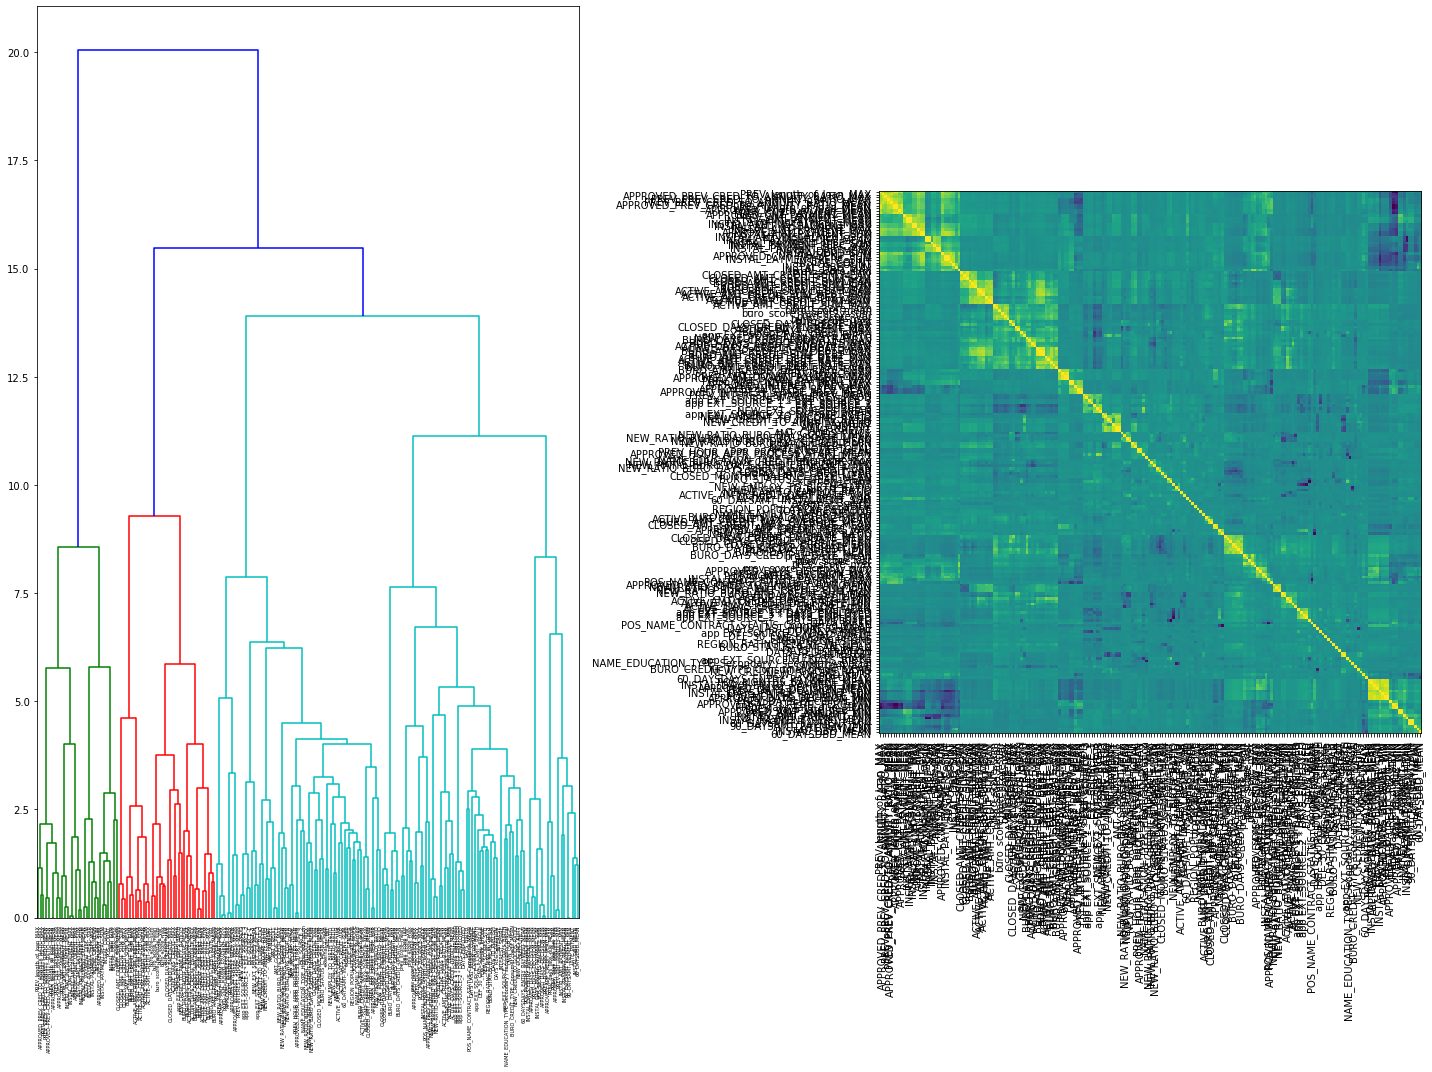

In [30]:
X=train2[ft]
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 15))
corr = spearmanr(X).correlation
corr_linkage = hierarchy.ward(corr)
dendro = hierarchy.dendrogram(
    corr_linkage, labels=X.columns.tolist(), ax=ax1, leaf_rotation=90
)
dendro_idx = np.arange(0, len(dendro['ivl']))

ax2.imshow(corr[dendro['leaves'], :][:, dendro['leaves']])
ax2.set_xticks(dendro_idx)
ax2.set_yticks(dendro_idx)
ax2.set_xticklabels(dendro['ivl'], rotation='vertical')
ax2.set_yticklabels(dendro['ivl'])
fig.tight_layout()
plt.show()

### Feature selection with inconsistency level 2
Inconsistency compares the height of a link in a cluster hierarchy with the average height of links below it

In [31]:
cluster_ids = hierarchy.fcluster(corr_linkage, 2, criterion='distance')
cluster_id_to_feature_ids = defaultdict(list)
for idx, cluster_id in enumerate(cluster_ids):
    cluster_id_to_feature_ids[cluster_id].append(idx)
selected_features = [v[0] for v in cluster_id_to_feature_ids.values()]

In [32]:
full=X.columns.tolist()

In [33]:
final_features=[full[x] for x in selected_features]

In [34]:
final_features

['NEW_EXT_SOURCES_MEAN',
 'prev_score_mean',
 'buro_score_sum',
 'prev_score_max',
 'external_1_refill',
 'EXT_SOURCE_2',
 'INTEREST',
 'app EXT_SOURCE_2 * DAYS_EMPLOYED',
 'buro_score_max',
 'app EXT_SOURCE_1 / DAYS_BIRTH',
 'DOWN_PAYMENT',
 'app EXT_SOURCE_1 * EXT_SOURCE_2',
 'NEW_CREDIT_TO_ANNUITY_RATIO',
 'AMT_ANNUITY',
 'app EXT_SOURCE_2 / DAYS_BIRTH',
 'DAYS_BIRTH',
 'LATE_PAYMENT',
 'app EXT_SOURCE_3 / DAYS_BIRTH',
 'CRED_UTIL_2',
 'ACTIVE_AMT_CREDIT_DEBT_RATE_MAX',
 'external_3_refill',
 'NEW_CREDIT_TO_GOODS_RATIO',
 'DAYS_ID_PUBLISH',
 'INSTAL_AMT_PAYMENT_SUM',
 'NAME_EDUCATION_TYPE_Higher education',
 'NEW_ANNUITY_TO_INCOME_RATIO',
 'NEW_EMPLOY_TO_BIRTH_RATIO',
 'POS_MONTHS_BALANCE_MAX',
 'CLOSED_DAYS_CREDIT_MAX',
 'OWN_CAR_AGE',
 'ACTIVE_AMT_CREDIT_SUM_SUM',
 'POS_MONTHS_BALANCE_MEAN',
 'NEW_CAR_TO_BIRTH_RATIO',
 'INSTAL_DPD_MEAN',
 'POS_COUNT',
 'ACTIVE_DAYS_CREDIT_MAX',
 'PREV_length_of_loan_MEAN',
 'BURO_DAYS_CREDIT_ENDDATE_MAX',
 'ACTIVE_DAYS_CREDIT_ENDDATE_MIN',
 'INSTA

In [35]:
len(final_features)

75